# Hamiltonian-based mixflows

Here we develop the code for dealing with continuous data
via mixflows using deterministic Hamiltonian dynamics.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [251]:
def lqN(x,rho,u,N,L,eps,lq0,gradlp,momentum='laplace',xi=np.pi/16):
    xc,rhoc,uc=np.copy(x),np.copy(rho),np.copy(u)
    if N==1: return lq0(xc,rhoc,uc)
    w=np.zeros((N,xc.shape[1]))
    w[0,:]=lq0(xc,rhoc,uc)
    LJ=np.zeros(x.shape[1])
    for n in range(N-1):
        print('Initial x: '+str(xc[0,-5:]))
        xc,rhoc,uc,tlj=flow(xc,rhoc,uc,1,L,eps,gradlp,momentum,xi,direction='bwd')
        print('Final x: '+str(xc[0,-5:]))
        print('logJacobian: '+str(tlj[-5:]))
        LJ=LJ+tlj
        print('cum lJ: '+str(LJ[:5]))
        w[n+1,:]=lq0(xc,rhoc,uc)+LJ
        print('weight: '+str(np.exp(w[n+1,-5:])))
        print()
    # end for
    return LogSumExp(w)-np.log(N)
    

def flow(x,rho,u,steps,L,eps,gradlp,momentum='laplace',xi=np.pi/16,direction='fwd'):
    xc,rhoc,uc=np.copy(x),np.copy(rho),np.copy(u)
    if steps==0: return xc,rhoc,uc,np.zeros(xc.shape[1])
    
    # define laplace functions
    if momentum=='laplace':
        lm = lambda rho : laplace_lm(rho)
        gradlm = lambda rho : laplace_gradlm(rho)
        Fm = lambda rho : laplace_Fm(rho)
        Qm = lambda p : laplace_Qm(p)
        
    ljs=np.zeros(xc.shape[1])
    for t in range(steps):
        if direction=='fwd': xc,rhoc,uc,tljs=T_Leps_fwd(xc,rhoc,uc,L,eps,gradlp,lm,gradlm,Fm,Qm,xi)
        if direction=='bwd': xc,rhoc,uc,tljs=T_Leps_bwd(xc,rhoc,uc,L,eps,gradlp,lm,gradlm,Fm,Qm,xi)
        ljs+=tljs
    # end for
    return xc,rhoc,uc,ljs
    

def T_Leps_fwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi=np.pi/16):
    #print('Starting forwards step')
    #print('Initial x: '+str(x[...,0]))
    #print('Initial rho: '+str(rho[...,0]))
    x,rho=Hamiltonian_update(x,rho,L,eps,gradlp,gradlm)
    u=(1+u+xi)%1
    lJ=lm(rho)
    rho=Qm((1+Fm(rho)+prz(x,u))%1)
    lJ=lJ-lm(rho)
    #print('Final x: '+str(x[...,0]))
    #print('Final rho: '+str(rho[...,0]))
    #print()
    return x,rho,u,lJ

def T_Leps_bwd(x,rho,u,L,eps,gradlp,lm,gradlm,Fm,Qm,xi=np.pi/16):
    #print('Starting backwards step')
    #print('Initial x: '+str(x[...,0]))
    print('Bwd map init')
    print('Initial rho: '+str(rho[...,-5:]))
    print('log m(rho): '+str(lm(rho[...,-5:])))
    lJ=lm(rho)
    rho=Qm((1+Fm(rho)-prz(x,u))%1)
    lJ=lJ-lm(rho)
    print('Final rho: '+str(rho[...,-5:]))
    print('log m(rho): '+str(lm(rho[...,-5:])))
    print('log J: '+str(lJ[-5:]))
    print('Bwd map done')
    u=(1+u-xi)%1
    x,rho=Hamiltonian_update(x,rho,L,-eps,gradlp,gradlm)
    #print('Final x: '+str(x[...,0]))
    #print('Final rho: '+str(rho[...,0]))
    #print()
    return x,rho,u,lJ

def Hamiltonian_update(x,rho,L,eps,gradlp,gradlm):
    #print('Starting Hamiltonian update')
    #print('Initial x: '+str(x))
    for l in range(L):
        rho+=eps*gradlp(x)/2
        x  -=eps*gradlm(rho)
        rho+=eps*gradlp(x)/2
    # end for
    #print('Final x: '+str(x))
    #print()
    return x,rho
    
    
def prz(x,u): return 0.5*np.sin(2*x+u[np.newaxis,:])+0.5
def laplace_lm(rho): return -np.sum(np.abs(rho),axis=0)-np.log(2)
def laplace_gradlm(rho): return -np.sign(rho)
def laplace_Fm(rho): return -0.5*np.sign(rho)*np.exp(-np.sign(rho)*rho)+0.5+0.5*np.sign(rho)
def laplace_Qm(p): return -np.sign(p-0.5)*np.log1p(-2*np.abs(p-0.5))


def LogSumExp(w):
    # LogSumExp trick
    #
    # inputs:
    #    w : (N,d) array, exponents
    #
    # outputs:
    #    w' : (d,) array, log(sum(exp(w))) over first axis of x
    wmax = np.amax(w,axis=0)
    return wmax + np.log(np.sum(np.exp(w-wmax[np.newaxis,:]),axis=0))

In [190]:
# define the target density and score
def lp(x): return -0.5*np.sum(x**2,axis=0)-0.5*x.shape[0]*np.log(2*np.pi)
def gradlp(x): return -x

# reference distribution
sd0=0.5
mu0=5
gauss_lp = lambda x : -0.5*np.sum((x-mu0)**2,axis=0)/sd0**2-0.5*x.shape[0]*np.log(2*np.pi*sd0**2)
def lq0(x,rho,u): return gauss_lp(x)#+laplace_lm(rho)
def randq0(size,M=1): return mu0+sd0*np.random.randn(M,size), np.random.laplace(size=(M,size)),np.random.rand(size)

M=1
d=1000
xi=np.pi/17
x,rho,u=randq0(d,M)

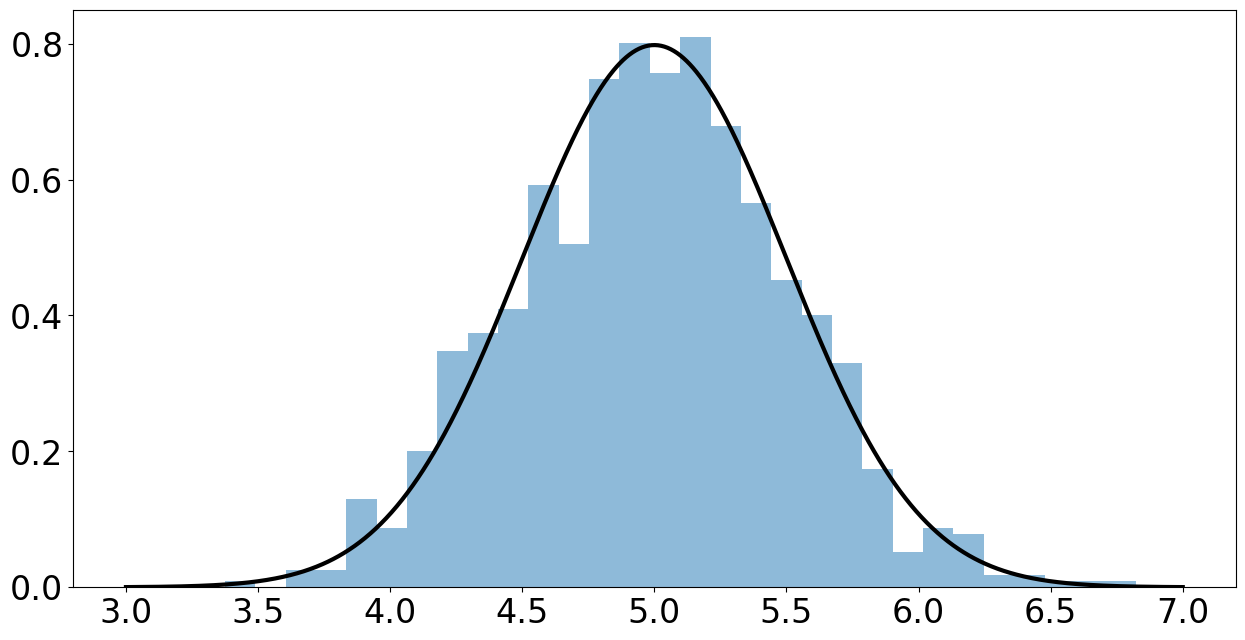

In [191]:
ls=np.linspace(5-4*sd0,5+4*sd0,1000)
for m in range(M): plt.hist(x[m,:],bins=30,density=True, alpha=0.5);
plt.plot(ls,np.exp(gauss_lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$q_0(x)$')
#plt.plot(np.sort(x[0,:]),np.exp(gauss_lp(np.sort(x))),lw=3,c='black',label=r'$q_0(x)$')

In [192]:
steps=1000
L=50
eps=0.01
tx,trho,tu,tljs=flow(x,rho,u,steps,L,eps,gradlp,momentum='laplace',direction='fwd',xi=xi)

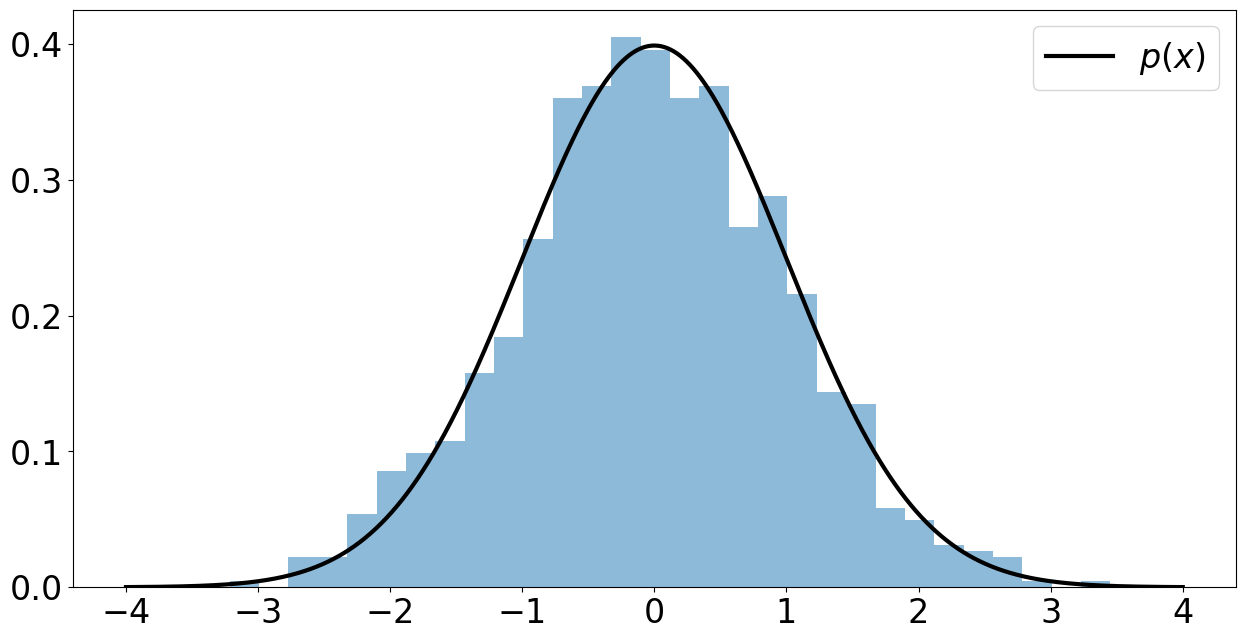

In [193]:
ls=np.linspace(-4,4,1000)
for m in range(M): plt.hist(tx[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$p(x)$')
plt.legend()

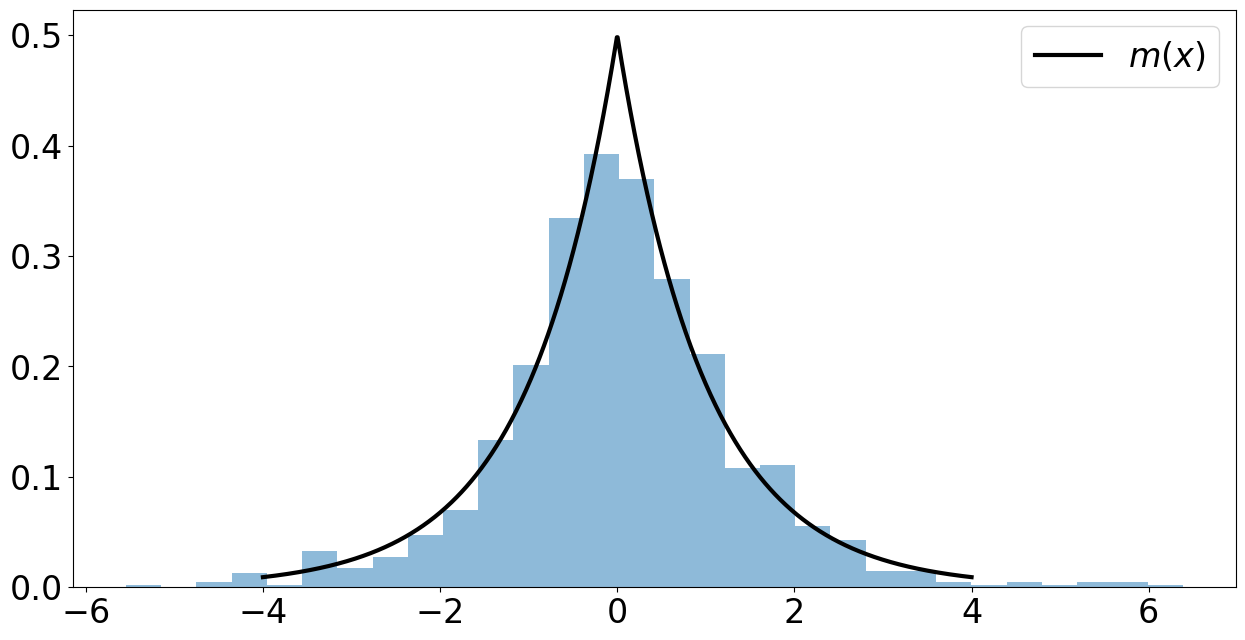

In [194]:
ls=np.linspace(-4,4,1000)
for m in range(M): plt.hist(trho[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(laplace_lm(ls[np.newaxis,:])),lw=3,c='black',label=r'$m(x)$')
plt.legend()

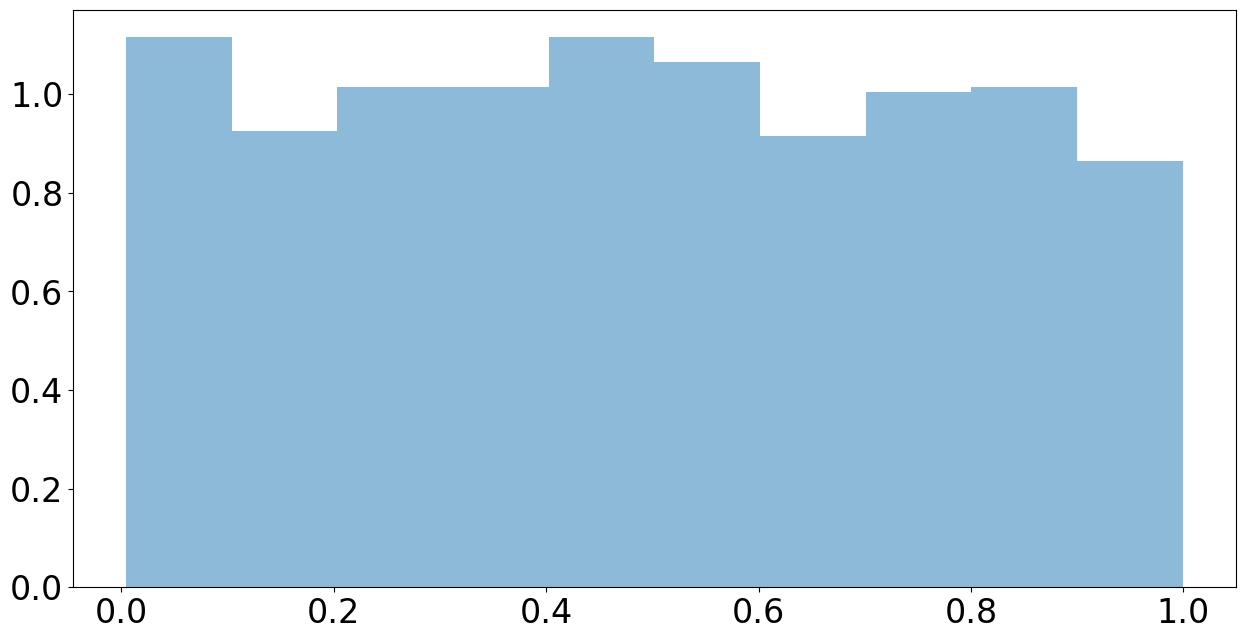

In [195]:
ls=np.linspace(-4,4,1000)
plt.hist(tu,bins=10,alpha=0.5,density=True);

In [196]:
ttx,ttrho,ttu,tljs=flow(tx,trho,tu,steps,L,eps,gradlp,momentum='laplace',direction='bwd',xi=xi)

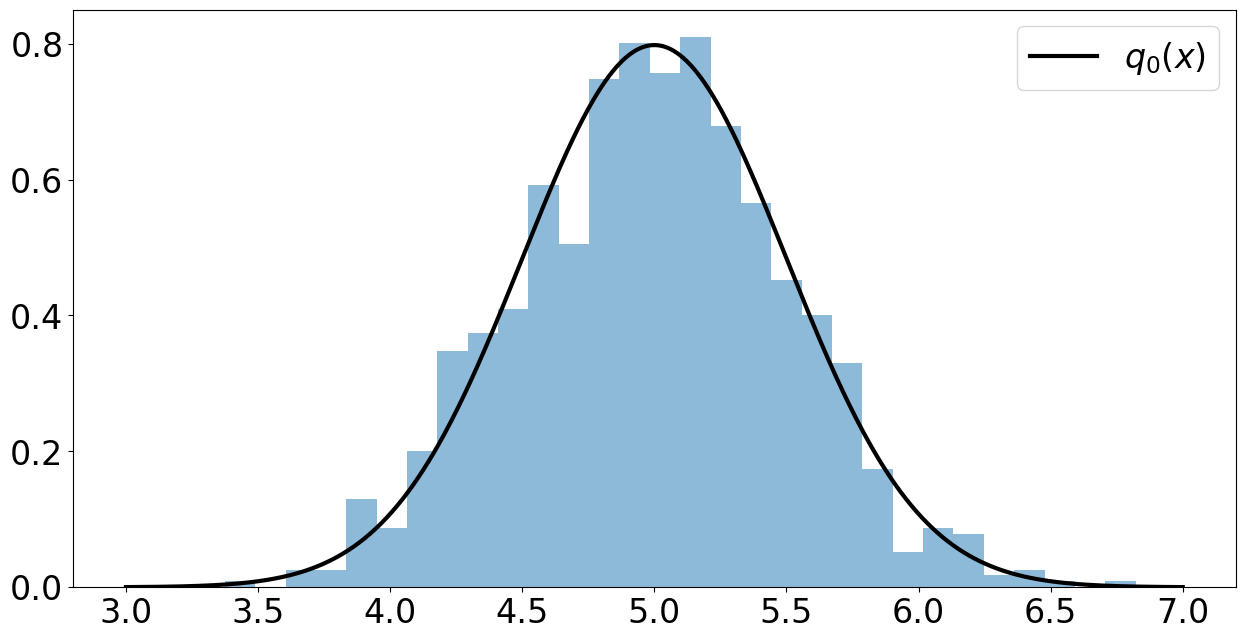

In [197]:
ls=np.linspace(mu0-4*sd0,mu0+4*sd0,1000)
for m in range(M): plt.hist(ttx[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(gauss_lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$q_0(x)$')
plt.legend()

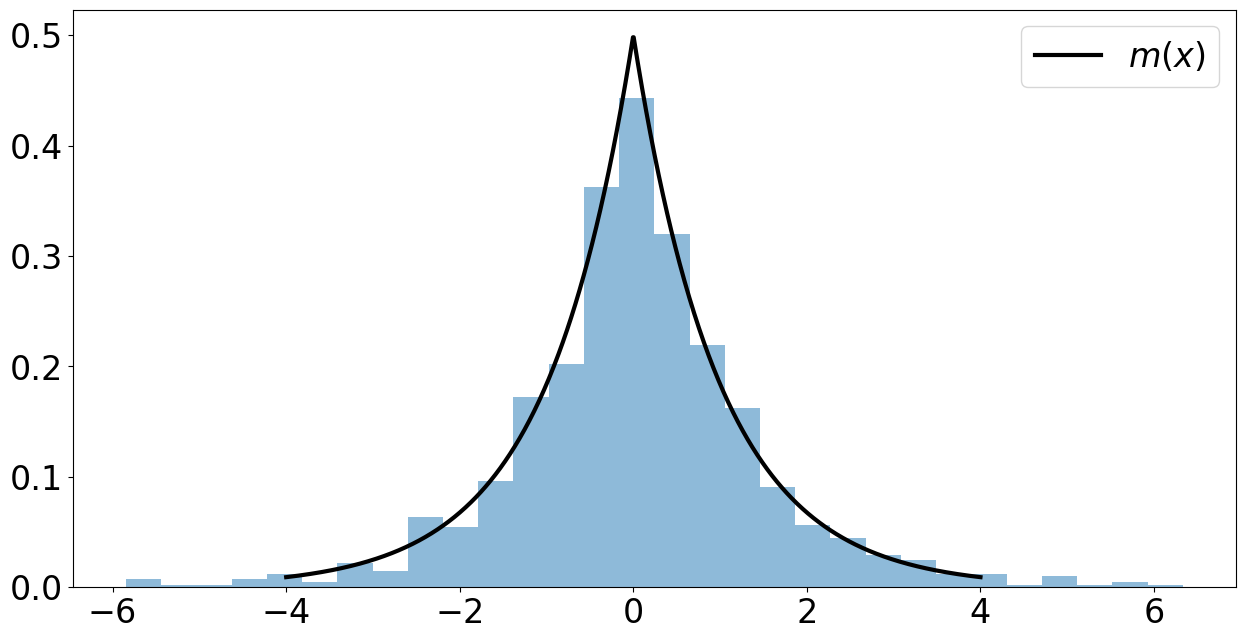

In [198]:
ls=np.linspace(-4,4,1000)
for m in range(M): plt.hist(ttrho[m,:],bins=30,alpha=0.5,density=True)
plt.plot(ls,np.exp(laplace_lm(ls[np.newaxis,:])),lw=3,c='black',label=r'$m(x)$')
plt.legend()

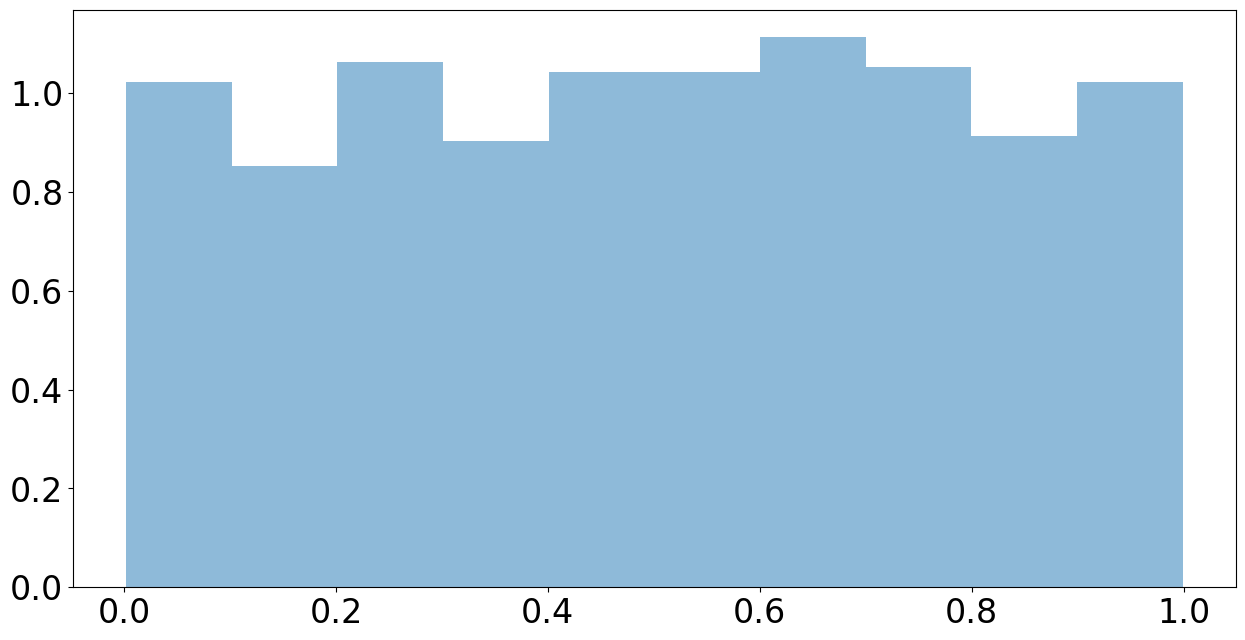

In [199]:
ls=np.linspace(-4,4,1000)
plt.hist(ttu,bins=10,alpha=0.5,density=True);

## Work in progress...

In [135]:
ls=np.linspace(-4,4,1000)
lapprox=lqN(ls[np.newaxis,:],np.random.laplace(size=(1,ls.shape[0])),np.random.rand(ls.shape[0]),steps,L,eps,lq0,gradlp,momentum='laplace',xi=xi)

Initial x: [3.96796797 3.97597598 3.98398398 3.99199199 4.        ]
Final x: [3.46796797 4.47597598 4.12398398 3.49199199 3.9       ]
logJacobian: [ 0.19112067  5.34757182 -0.1252391   0.62342547 -0.63035613]
cum lJ: [0. 0. 0. 0. 0.]
weight: [0.00729887 0.46070668 0.17194176 0.0084468  0.07094919]

Initial x: [3.46796797 4.47597598 4.12398398 3.49199199 3.9       ]
Final x: [2.96796797 4.11597598 4.18398398 3.99199199 3.4       ]
logJacobian: [ 0.46085206 -5.15483312  0.47614881  1.94836897  0.13545294]
cum lJ: [0. 0. 0. 0. 0.]
weight: [2.06729432e-04 1.67162597e-01 2.10650350e-01 1.04564451e-01
 4.76817640e-03]

Initial x: [2.96796797 4.11597598 4.18398398 3.99199199 3.4       ]
Final x: [2.54796797 3.81597598 4.22398398 4.37199199 3.5       ]
logJacobian: [-4.12060168 -1.40726639  0.23160596 -1.06984624 -2.1286899 ]
cum lJ: [0. 0. 0. 0. 0.]
weight: [4.78170431e-06 4.83341402e-02 2.39262724e-01 3.62554863e-01
 8.86369682e-03]

Initial x: [2.54796797 3.81597598 4.22398398 4.37199199 3.

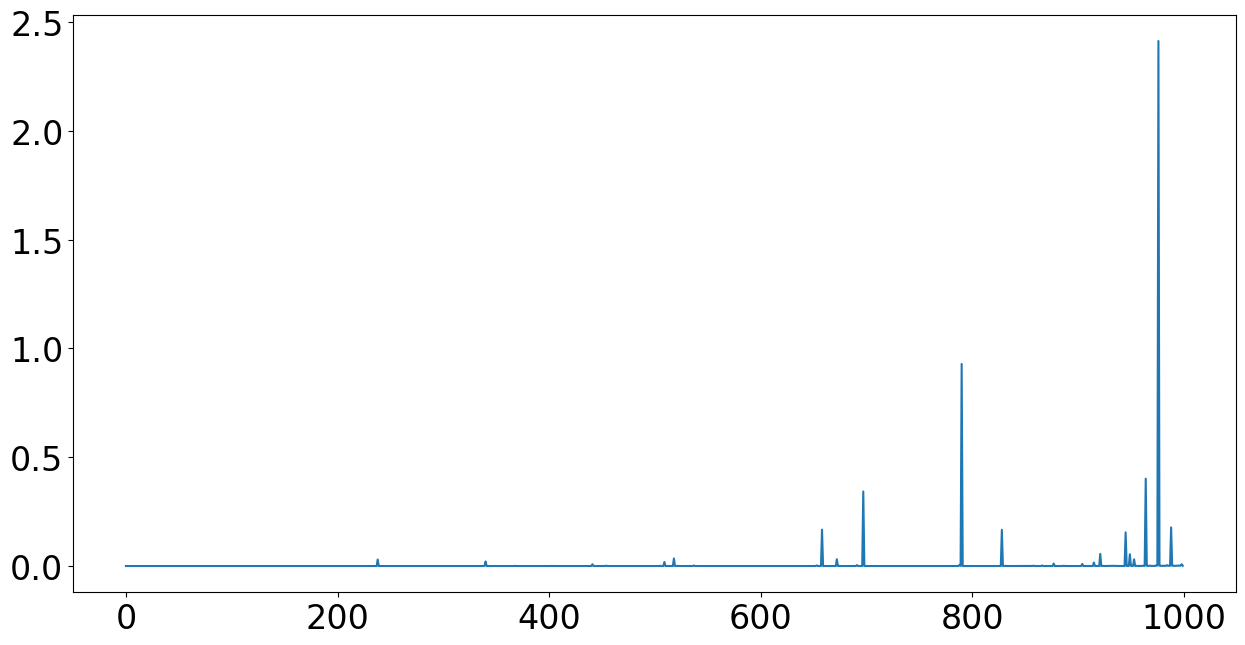

In [119]:
plt.plot(np.arange(0,lapprox.shape[0]),np.exp(lapprox))

In [200]:
ls=np.linspace(-4,4,10000)
#tttx,tttrho,tttu,tljs=flow(ls[np.newaxis,:],np.random.laplace(size=(1,ls.shape[0])),np.random.rand(ls.shape[0]),steps,L,eps,gradlp,momentum='laplace',direction='bwd',xi=xi)
tttx,tttrho,tttu,tljs=flow(tx,trho,tu,steps,L,eps,gradlp,momentum='laplace',direction='bwd',xi=xi)
#tttx,tttrho,tttu,tljs=flow(np.random.randn(1,ls.shape[0]),trho[0,:].reshape(1,ls.shape[0]),tu,steps,L,eps,gradlp,momentum='laplace',direction='bwd',xi=xi)


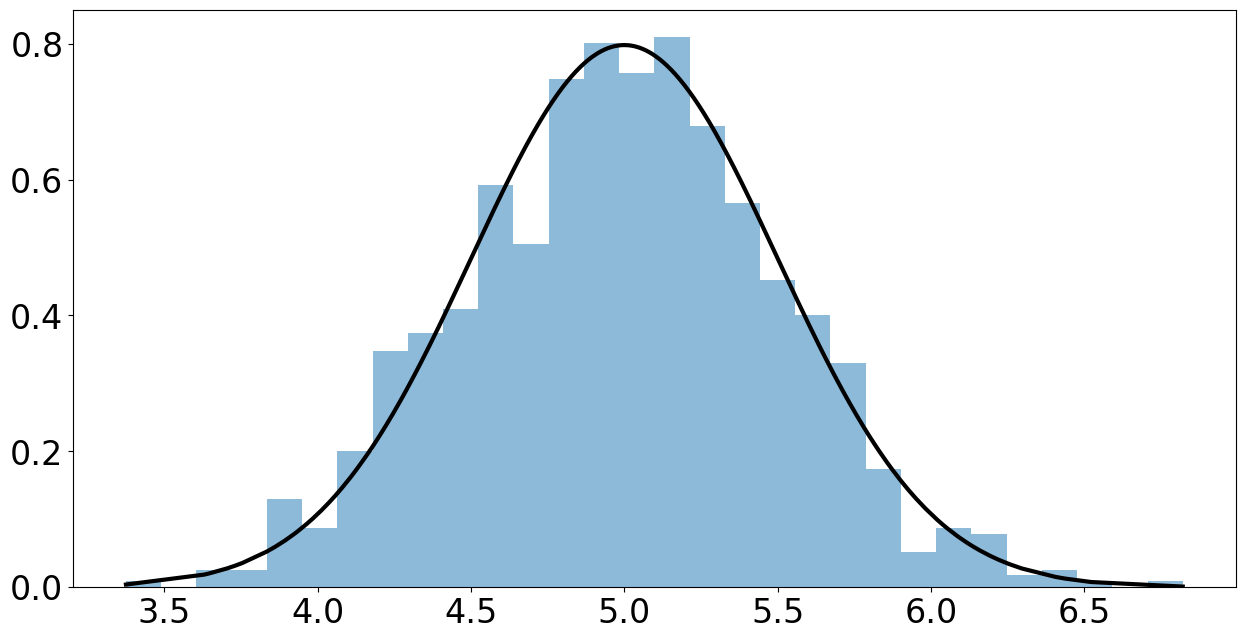

In [201]:
ls=np.linspace(mu0-4*sd0,mu0+4*sd0,10000)
plt.hist(tttx[0,:],bins=30,alpha=0.5,density=True);
mytttx=np.sort(tttx)
mytttrho=tttrho[0,np.argsort(tttx[0,:])]
mytttu=tttu[np.argsort(tttx[0,:])]
mytttljs=tljs[np.argsort(tttx[0,:])]
#plt.plot(mytttx[0,:],np.exp(lq0(mytttx,mytttrho,mytttu)))
#plt.plot(ls,np.exp(gauss_lp(ls[np.newaxis,:])),lw=3,c='black',label=r'$q_0(x)$')
plt.plot(mytttx[0,:],np.exp(gauss_lp(mytttx)),lw=3,c='black',label=r'$q_0(x)$')

In [244]:
def mylqN(x,rho,u,N,L,eps,lq0,gradlp,momentum='laplace',xi=np.pi/16):
    xc,rhoc,uc=np.copy(x),np.copy(rho),np.copy(u)
    if N==1: return gauss_lp(xc)
    w=np.zeros((N,xc.shape[1]))
    w[0,:]=gauss_lp(xc)
    LJ=np.zeros(x.shape[1])
    for n in range(N-1):
        print('Initial x: '+str(xc[0,-5:]))
        xc,rhoc,uc,tlj=flow(xc,rhoc,uc,1,L,eps,gradlp,momentum,xi,direction='bwd')
        print('Final x: '+str(xc[0,-5:]))
        print('Jacobian: '+str(np.exp(tlj[-5:])))
        LJ=LJ+tlj
        #print('cum lJ: '+str(LJ[:5]))
        w[n+1,:]=lq0(xc,rhoc,uc)+LJ
        print('gauss weight: '+str(np.exp(gauss_lp(xc[:,-5:]))))
        print('lap weight: '+str(np.exp(laplace_lm(rhoc[:,-5:]))))
        print('jac weight: '+str(np.exp(LJ[-5:])))
        print('total weight: '+str(np.exp(w[n+1,-5:])))
        print()
    # end for
    #return LogSumExp(w)-np.log(N)
    return w,np.log(np.sum(np.exp(w),axis=0))-np.log(N+1)

def myflow(x,rho,u,steps,L,eps,gradlp,momentum='laplace',xi=np.pi/16,direction='fwd'):
    xc,rhoc,uc=np.copy(x),np.copy(rho),np.copy(u)
    if steps==0: return xc,rhoc,uc,np.zeros(xc.shape[1])
    
    # define laplace functions
    if momentum=='laplace':
        lm = lambda rho : laplace_lm(rho)
        gradlm = lambda rho : laplace_gradlm(rho)
        Fm = lambda rho : laplace_Fm(rho)
        Qm = lambda p : laplace_Qm(p)
        
    ljs=np.zeros(xc.shape[1])
    for t in range(steps):
        print('Initial x: '+str(xc[0,-5:]))
        if direction=='fwd': xc,rhoc,uc,tljs=T_Leps_fwd(xc,rhoc,uc,L,eps,gradlp,lm,gradlm,Fm,Qm,xi)
        if direction=='bwd': xc,rhoc,uc,tljs=T_Leps_bwd(xc,rhoc,uc,L,eps,gradlp,lm,gradlm,Fm,Qm,xi)
        print('Final x: '+str(xc[0,-5:]))
        print('weight: '+str(np.exp(gauss_lp(xc))[-5:]))
        print()
        ljs+=tljs
    # end for
    return xc,rhoc,uc,ljs

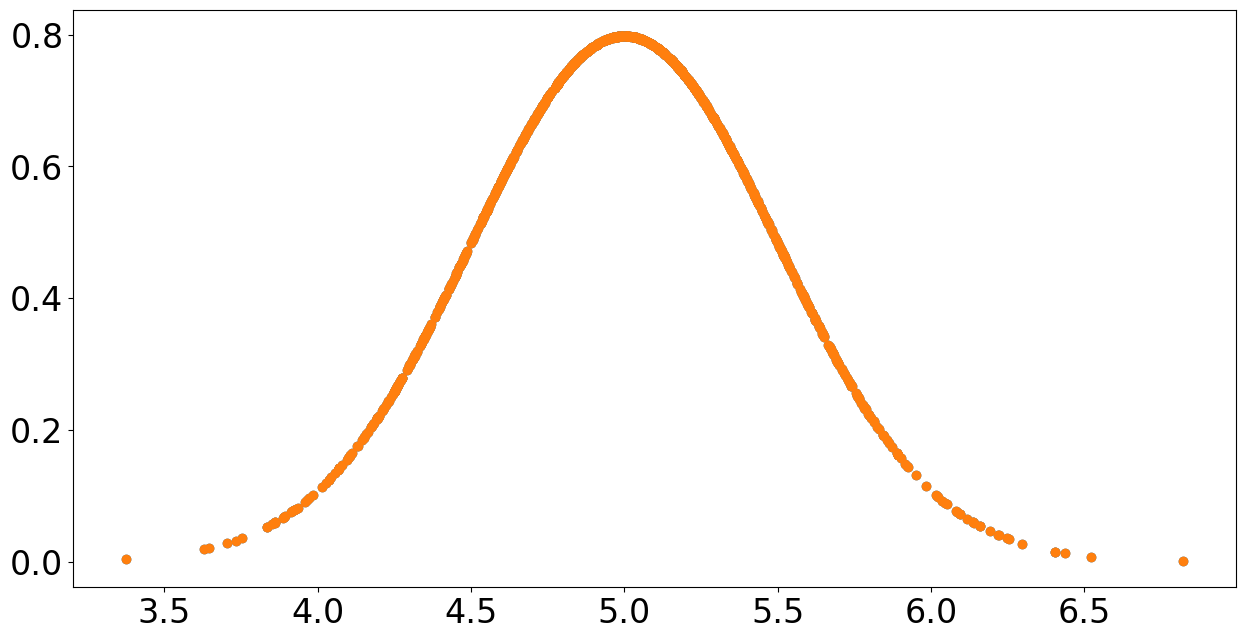

In [211]:
plt.scatter(tttx[0,:],np.exp(lq0(tttx,tttrho,tttu)))
plt.scatter(mytttx[0,:],np.exp(gauss_lp(mytttx)))

Initial x: [0.47679217 1.43162731 0.03979118 1.58616685 0.80075544]
Final x: [0.21679217 0.95162731 0.53979118 2.08616685 0.30075544]
weight: [1.07010442e-20 4.63827334e-15 4.19467112e-18 3.36706739e-08
 5.25989758e-20]

Initial x: [0.21679217 0.95162731 0.53979118 2.08616685 0.30075544]
Final x: [-0.28320783  0.45162731  1.03979118  2.26616685 -0.19924456]
weight: [4.54608328e-25 8.56716749e-19 1.90387675e-14 2.57182800e-07
 2.64312730e-24]

Initial x: [-0.28320783  0.45162731  1.03979118  2.26616685 -0.19924456]
Final x: [ 0.21679217 -0.04837269  0.53979118  1.76616685  0.30075544]
weight: [1.07010442e-20 5.82134978e-23 4.19467112e-18 6.58441775e-10
 5.25989758e-20]

Initial x: [ 0.21679217 -0.04837269  0.53979118  1.76616685  0.30075544]
Final x: [ 0.71679217  0.45162731  0.03979118  1.26616685 -0.19924456]
weight: [9.26660072e-17 8.56716749e-19 3.39987164e-22 6.20152291e-13
 2.64312730e-24]

Initial x: [ 0.71679217  0.45162731  0.03979118  1.26616685 -0.19924456]
Final x: [ 0.77679

Final x: [ 1.33679217 -0.50837269  0.93979118  1.14616685 -1.49924456]
weight: [1.76305230e-12 3.52424694e-27 3.82819636e-15 1.00376204e-13
 1.63149582e-37]

Initial x: [ 1.33679217 -0.50837269  0.93979118  1.14616685 -1.49924456]
Final x: [ 1.17679217 -1.00837269  0.43979118  1.64616685 -0.99924456]
weight: [1.60637269e-13 3.51081029e-32 6.90548833e-19 1.35481647e-10
 4.37130214e-32]

Initial x: [ 1.17679217 -1.00837269  0.43979118  1.64616685 -0.99924456]
Final x: [ 0.67679217 -0.52837269 -0.06020882  1.14616685 -0.49924456]
weight: [4.65482056e-17 2.26640973e-27 4.58247499e-23 1.00376204e-13
 4.30864987e-27]

Initial x: [ 0.67679217 -0.52837269 -0.06020882  1.14616685 -0.49924456]
Final x: [ 0.17679217 -0.02837269  0.43979118  1.20616685 -0.99924456]
weight: [4.96209523e-21 8.71113394e-23 6.90548833e-19 2.51299417e-13
 4.37130214e-32]

Initial x: [ 0.17679217 -0.02837269  0.43979118  1.20616685 -0.99924456]
Final x: [-0.32320783  0.47162731  0.11979118  1.70616685 -0.75924456]
weigh

Final x: [-0.32320783 -0.14837269  0.15979118  0.76616685  0.72075544]
weight: [1.94595487e-25 7.57435480e-24 3.57245422e-21 2.14874484e-16
 9.91736384e-17]

Initial x: [-0.32320783 -0.14837269  0.15979118  0.76616685  0.72075544]
Final x: [-0.80320783  0.35162731 -0.34020882  0.26616685  0.22075544]
weight: [4.46969076e-30 1.36150144e-19 1.35415217e-25 2.73890430e-20
 1.15436833e-20]

Initial x: [-0.80320783  0.35162731 -0.34020882  0.26616685  0.22075544]
Final x: [-0.30320783  0.85162731  0.15979118 -0.23383315 -0.27924456]
weight: [2.97668248e-25 9.00318306e-16 3.57245422e-21 1.28432338e-24
 4.94308500e-25]

Initial x: [-0.30320783  0.85162731  0.15979118 -0.23383315 -0.27924456]
Final x: [-0.80320783  0.35162731  0.65979118 -0.63383315 -0.77924456]
weight: [4.46969076e-30 1.36150144e-19 3.46714011e-17 2.15208977e-28
 7.78676866e-30]

Initial x: [-0.80320783  0.35162731  0.65979118 -0.63383315 -0.77924456]
Final x: [-1.30320783 -0.14837269  0.55979118 -0.13383315 -0.27924456]
weigh

Final x: [ 6.16792171e-01 -3.88372690e-01 -2.08816948e-04  4.06166851e-01
  1.26075544e+00]
weight: [1.63743908e-17 4.81771899e-26 1.53250594e-22 3.73116090e-19
 5.71969242e-13]

Initial x: [ 6.16792171e-01 -3.88372690e-01 -2.08816948e-04  4.06166851e-01
  1.26075544e+00]
Final x: [0.11679217 0.11162731 0.49979118 0.90616685 1.76075544]
weight: [1.54814617e-21 1.39950764e-21 2.04824131e-18 2.21232798e-15
 6.13892031e-10]

Initial x: [0.11679217 0.11162731 0.49979118 0.90616685 1.76075544]
Final x: [0.61679217 0.61162731 0.99979118 0.72616685 1.66075544]
weight: [1.63743908e-17 1.49559706e-17 1.00708376e-14 1.08792321e-16
 1.64699276e-10]

Initial x: [0.61679217 0.61162731 0.99979118 0.72616685 1.66075544]
Final x: [0.83679217 0.79162731 0.49979118 0.22616685 1.16075544]
weight: [7.03551773e-16 3.30279389e-16 2.04824131e-18 1.28010825e-20
 1.25635818e-13]

Initial x: [0.83679217 0.79162731 0.49979118 0.22616685 1.16075544]
Final x: [ 3.36792171e-01  2.91627310e-01 -2.08816948e-04 -2.738

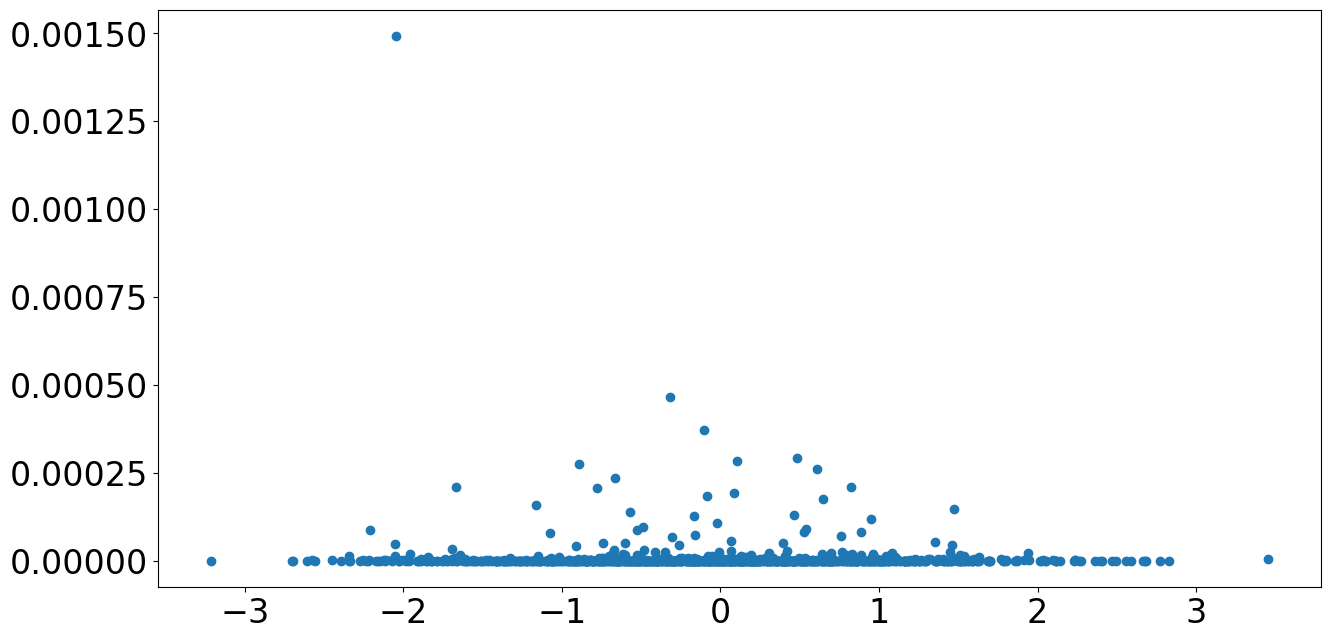

In [212]:
plt.scatter(tx[0,:],np.exp(mylqN(tx,trho,tu,steps+1,L,eps,lq0,gradlp)));

In [252]:
w,lap=mylqN(tx,trho,tu,steps+1,L,eps,lq0,gradlp,momentum='laplace',xi=xi)
print(np.exp(w[-10:,-5:]))
print(np.sum(np.exp(w[:,-5:]),axis=0))
print(np.exp(np.log(np.sum(np.exp(w[:,-5:]),axis=0))-np.log(steps+1)))
print(np.exp(lap[-5:]))
print((np.exp(lap)/np.sum(lap))[-5:])
print(np.exp(gauss_lp(newx))[-5:])

Initial x: [0.47679217 1.43162731 0.03979118 1.58616685 0.80075544]
Bwd map init
Initial rho: [[-0.10260294  1.55622914 -1.05966778 -0.63256308  0.15588144]]
log m(rho): [-0.79575012 -2.24937632 -1.75281496 -1.32571027 -0.84902862]
Final rho: [[-0.06241902 -0.01214088 -0.68824036 -1.6729675   0.41881177]]
log m(rho): [-0.7555662  -0.70528806 -1.38138754 -2.36611468 -1.11195895]
log J: [-0.04018392 -1.54408826 -0.37142742  1.04040441  0.26293033]
Bwd map done
Final x: [0.21679217 0.95162731 0.53979118 2.08616685 0.30075544]
Jacobian: [0.96061275 0.21350644 0.68974906 2.83036142 1.30073609]
gauss weight: [1.07010442e-20 4.63827334e-15 4.19467112e-18 3.36706739e-08
 5.25989758e-20]
lap weight: [0.42753281 0.2775595  0.29040118 0.23503255 0.24973956]
jac weight: [0.96061275 0.21350644 0.68974906 2.83036142 1.30073609]
total weight: [1.02795595e-20 9.90301247e-16 2.89327048e-18 9.53001763e-08
 6.84173862e-20]

Initial x: [0.21679217 0.95162731 0.53979118 2.08616685 0.30075544]
Bwd map init


Final x: [ 1.23679217  1.35162731 -1.70020882 -2.21383315 -0.19924456]
Jacobian: [0.96327776 0.51310576 1.03185333 3.73357773 1.29758083]
gauss weight: [3.99222424e-13 2.19017883e-12 8.10123068e-40 5.02459841e-46
 2.64312730e-24]
lap weight: [0.05251105 0.15359069 0.28797419 0.13754343 0.27916165]
jac weight: [16.27222333  0.62743777  2.66377379  6.69324971  1.08728916]
total weight: [6.49623643e-12 1.37420092e-12 2.15798460e-39 3.36308918e-45
 2.87384365e-24]

Initial x: [ 1.23679217  1.35162731 -1.70020882 -2.21383315 -0.19924456]
Bwd map init
Initial rho: [[-2.25358439 -1.18031692 -0.55173725  1.29066838 -0.58281711]]
log m(rho): [-2.94673157 -1.8734641  -1.24488443 -1.98381556 -1.27596429]
Final rho: [[ 0.32834359  0.35817764 -1.85072774 -2.10293079  0.50205282]]
log m(rho): [-1.02149077 -1.05132482 -2.54387492 -2.79607797 -1.1952    ]
log J: [-1.9252408  -0.82213928  1.29899049  0.81226241 -0.08076429]
Bwd map done
Final x: [ 0.73679217  0.85162731 -1.20020882 -1.71383315 -0.69924

Final rho: [[ 0.02077619  0.01772757  0.96552201 -0.27296604 -0.52723611]]
log m(rho): [-0.71392337 -0.71087476 -1.65866919 -0.96611322 -1.22038329]
log J: [-0.40073381 -0.26555563  0.22408489  0.17996645 -0.0326904 ]
Bwd map done
Final x: [ 0.11679217 -0.26837269 -0.34020882 -0.15383315  0.94075544]
Jacobian: [0.66982834 0.76677979 1.25117723 1.1971772  0.96783815]
gauss weight: [1.54814617e-21 6.21729158e-25 1.35415217e-25 6.76835877e-24
 3.88861159e-15]
lap weight: [0.49160737 0.49574757 0.19917633 0.31097903 0.4168597 ]
jac weight: [0.808103   0.0806637  0.96284723 0.25941415 1.18988405]
total weight: [1.25106157e-21 5.01509724e-26 1.30384166e-25 1.75580802e-24
 4.62699690e-15]

Initial x: [ 0.11679217 -0.26837269 -0.34020882 -0.15383315  0.94075544]
Bwd map init
Initial rho: [[-0.01692773  0.00854123  0.9204176  -0.47488262 -0.18185839]]
log m(rho): [-0.71007491 -0.70168841 -1.61356478 -1.1680298  -0.87500557]
Final rho: [[ 0.28694782 -1.02456732 -0.42075364  0.78562342  0.0200653

Final x: [ 0.09679217  0.91162731 -0.96020882  0.04616685  0.48075544]
Jacobian: [1.79779866 0.80979796 0.74108251 2.26789386 0.22710613]
gauss weight: [1.04665731e-21 2.41911686e-15 1.11200895e-31 3.85802334e-22
 1.45295216e-18]
lap weight: [0.06807473 0.13059407 0.41204963 0.0073275  0.33318882]
jac weight: [ 5.73021916  0.46781524  0.72875525 10.93388927  1.05639627]
total weight: [5.99757577e-21 1.13169974e-15 8.10382360e-32 4.21832000e-21
 1.53489324e-18]

Initial x: [ 0.09679217  0.91162731 -0.96020882  0.04616685  0.48075544]
Bwd map init
Initial rho: [[ 1.99400204 -1.34251428  0.19346429  4.22297367 -0.40589874]]
log m(rho): [-2.68714922 -2.03566146 -0.88661147 -4.91612085 -1.09904592]
Final rho: [[-2.5187156  -0.89838607  0.1054334  -0.85402701 -0.38091783]]
log m(rho): [-3.21186278 -1.59153325 -0.79858058 -1.54717419 -1.07406501]
log J: [ 0.52471356 -0.44412821 -0.08803089 -3.36894666 -0.02498091]
Bwd map done
Final x: [ 0.59679217  1.41162731 -0.66020882  0.54616685  0.98075

Final rho: [[ 1.03014327  0.71753342 -0.20992167  0.17941368 -0.40728218]]
log m(rho): [-1.72329045 -1.4106806  -0.90306885 -0.87256086 -1.10042936]
log J: [ 0.10381068 -0.35713077 -0.46982317 -0.31133271 -0.00969565]
Bwd map done
Final x: [-0.04320783 -1.06837269  0.85979118 -0.35383315  1.08075544]
Jacobian: [1.1093904  0.699681   0.62511279 0.73247014 0.9903512 ]
gauss weight: [6.46094359e-23 8.24183086e-33 1.03079149e-15 1.01184683e-25
 3.63076743e-14]
lap weight: [0.16094597 0.36733014 0.36713667 0.44014798 0.47296082]
jac weight: [2.09794635 0.19366277 0.75110332 0.19971173 1.15456637]
total weight: [1.35547130e-22 1.59613582e-33 7.74230910e-16 2.02077684e-26
 4.19196196e-14]

Initial x: [-0.04320783 -1.06837269  0.85979118 -0.35383315  1.08075544]
Bwd map init
Initial rho: [[1.13353936 0.30834708 0.30887392 0.12749711 0.05559554]]
log m(rho): [-1.82668654 -1.00149426 -1.0020211  -0.82064429 -0.74874272]
Final rho: [[-0.55742823  0.27762278  0.40887596  1.85588994  4.21010175]]
l

Final x: [3.13679217 2.93162731 0.19979118 3.36616685 2.04075544]
Jacobian: [ 2.31854964  1.52243152  0.53090418 15.97821701  0.80705491]
gauss weight: [7.70186257e-04 1.53452034e-04 7.72518853e-21 3.83106339e-03
 1.97512682e-08]
lap weight: [0.34006319 0.21577294 0.34150496 0.11738708 0.13531362]
jac weight: [133.84852759  13.2211174    0.52902143 191.72786028  17.05803011]
total weight: [1.03088296e-01 2.02880736e-03 4.08679026e-21 7.34521586e-01
 3.36917727e-07]

Initial x: [3.13679217 2.93162731 0.19979118 3.36616685 2.04075544]
Bwd map init
Initial rho: [[ 0.38547666  0.84038147 -0.3812459  -1.44913128  1.3070129 ]]
log m(rho): [-1.07862384 -1.53352865 -1.07439308 -2.14227846 -2.00016008]
Final rho: [[-3.65891956 -2.21032039  0.00658073 -0.3426126   0.80435075]]
log m(rho): [-4.35206674 -2.90346757 -0.69972791 -1.03575978 -1.49749793]
log J: [ 3.2734429   1.36993892 -0.37466517 -1.10651868 -0.50266215]
Bwd map done
Final x: [ 3.63679217  3.43162731 -0.16020882  3.06616685  1.54075

In [203]:
newx,_,_,_=myflow(tx,trho,tu,steps,L,eps,gradlp,momentum='laplace',direction='bwd',xi=xi);

Initial x: [0.47679217 1.43162731 0.03979118 1.58616685 0.80075544]
Final x: [0.21679217 0.95162731 0.53979118 2.08616685 0.30075544]
weight: [1.07010442e-20 4.63827334e-15 4.19467112e-18 3.36706739e-08
 5.25989758e-20]

Initial x: [0.21679217 0.95162731 0.53979118 2.08616685 0.30075544]
Final x: [-0.28320783  0.45162731  1.03979118  2.26616685 -0.19924456]
weight: [4.54608328e-25 8.56716749e-19 1.90387675e-14 2.57182800e-07
 2.64312730e-24]

Initial x: [-0.28320783  0.45162731  1.03979118  2.26616685 -0.19924456]
Final x: [ 0.21679217 -0.04837269  0.53979118  1.76616685  0.30075544]
weight: [1.07010442e-20 5.82134978e-23 4.19467112e-18 6.58441775e-10
 5.25989758e-20]

Initial x: [ 0.21679217 -0.04837269  0.53979118  1.76616685  0.30075544]
Final x: [ 0.71679217  0.45162731  0.03979118  1.26616685 -0.19924456]
weight: [9.26660072e-17 8.56716749e-19 3.39987164e-22 6.20152291e-13
 2.64312730e-24]

Initial x: [ 0.71679217  0.45162731  0.03979118  1.26616685 -0.19924456]
Final x: [ 0.95679

Final x: [-2.10320783 -1.68837269  0.87979118  0.00616685  0.74075544]
weight: [1.19342797e-44 1.11223199e-39 1.43439571e-15 1.74079457e-22
 1.39548443e-16]

Initial x: [-2.10320783 -1.68837269  0.87979118  0.00616685  0.74075544]
Final x: [-1.60320783 -1.60837269  0.37979118  0.50616685  1.24075544]
weight: [1.07008161e-38 9.33572146e-39 2.29484749e-19 2.29714624e-18
 4.23750845e-13]

Initial x: [-1.60320783 -1.60837269  0.37979118  0.50616685  1.24075544]
Final x: [-1.40320783 -1.10837269 -0.12020882  1.00616685  0.74075544]
weight: [1.94474525e-36 3.11143141e-33 1.35065428e-23 1.11515511e-14
 1.39548443e-16]

Initial x: [-1.40320783 -1.10837269 -0.12020882  1.00616685  0.74075544]
Final x: [-0.90320783 -0.60837269  0.37979118  0.58616685  0.24075544]
weight: [4.30002650e-31 3.81485553e-28 2.29484749e-19 9.55337211e-18
 1.69061583e-20]

Initial x: [-0.90320783 -0.60837269  0.37979118  0.58616685  0.24075544]
Final x: [-0.40320783 -1.10837269  0.87979118  0.08616685  0.74075544]
weigh

Final x: [ 0.21679217  0.21162731 -0.36020882 -0.49383315  0.68075544]
weight: [1.07010442e-20 9.69363580e-21 8.82637098e-26 4.85301823e-27
 4.98487344e-17]

Initial x: [ 0.21679217  0.21162731 -0.36020882 -0.49383315  0.68075544]
Final x: [ 0.71679217 -0.28837269  0.13979118  0.00616685  0.36075544]
weight: [9.26660072e-17 4.07578986e-25 2.42355655e-21 1.74079457e-22
 1.61307962e-19]

Initial x: [ 0.71679217 -0.28837269  0.13979118  0.00616685  0.36075544]
Final x: [ 1.21679217  0.21162731 -0.36020882  0.50616685 -0.13924456]
weight: [2.95202655e-13 9.69363580e-21 8.82637098e-26 2.29714624e-18
 9.13927896e-24]

Initial x: [ 1.21679217  0.21162731 -0.36020882  0.50616685 -0.13924456]
Final x: [ 0.71679217  0.71162731  0.13979118  0.28616685 -0.63924456]
weight: [9.26660072e-17 8.48139189e-17 2.42355655e-21 3.99668233e-20
 1.90490614e-28]

Initial x: [ 0.71679217  0.71162731  0.13979118  0.28616685 -0.63924456]
Final x: [ 0.21679217  1.21162731 -0.24020882 -0.21383315 -1.13924456]
weigh

Final x: [-0.44320783 -0.52837269  0.89979118 -0.65383315 -0.85924456]
weight: [1.46873007e-26 2.26640973e-27 1.99283920e-15 1.37016710e-28
 1.20957336e-30]

Initial x: [-0.44320783 -0.52837269  0.89979118 -0.65383315 -0.85924456]
Final x: [-0.94320783 -0.12837269  1.39979118 -1.15383315 -1.35924456]
weight: [1.66680385e-31 1.14253890e-23 4.40272079e-12 1.02039711e-33
 5.97323786e-36]

Initial x: [-0.94320783 -0.12837269  1.39979118 -1.15383315 -1.35924456]
Final x: [-1.32320783 -0.62837269  0.89979118 -1.65383315 -1.11924456]
weight: [1.48999446e-35 2.43374928e-28 1.99283920e-15 2.79557031e-39
 2.38502269e-33]

Initial x: [-1.32320783 -0.62837269  0.89979118 -1.65383315 -1.11924456]
Final x: [-0.82320783 -1.12837269  1.39979118 -1.15383315 -0.61924456]
weight: [2.80741070e-30 1.90715588e-33 4.40272079e-12 1.02039711e-33
 2.98850213e-28]

Initial x: [-0.82320783 -1.12837269  1.39979118 -1.15383315 -0.61924456]
Final x: [-0.32320783 -1.62837269  0.89979118 -1.65383315 -1.11924456]
weigh

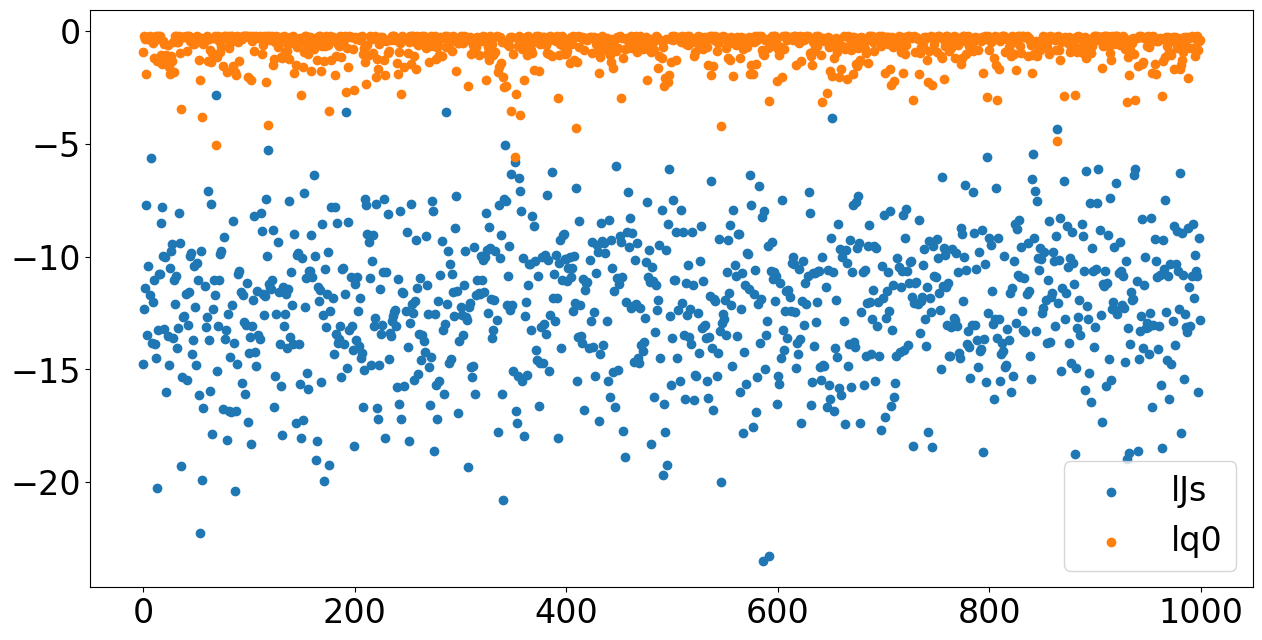

In [134]:
plt.scatter(np.arange(0,tljs.shape[0]),-tljs,label='lJs')
plt.scatter(np.arange(0,tljs.shape[0]),lq0(tttx,tttrho,tttu),label='lq0')
plt.legend()

In [72]:
print(gauss_lp(mytttx)[:5])
print(mytttrho.shape)

[-4.84596454 -4.83882675 -4.71353987 -4.16124342 -4.11803574]
(1000,)


In [125]:
ls=np.linspace(-4,4,10)
myrho=np.sort(np.random.laplace(size=(1,ls.shape[0])))
myu=np.sort(np.random.rand(ls.shape[0]))
#plt.plot(ls,np.exp(lqN(ls[np.newaxis,:],myrho,myu,steps,L,eps,lq0,gradlp,momentum='laplace',xi=xi)),lw=3,c='black')